<a href="https://colab.research.google.com/github/datamino/PINNs-Research/blob/main/PDE-Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 0: Loss=5.14e-01, u_loss=5.13e-01, f_loss=5.37e-04
Epoch 500: Loss=9.58e-02, u_loss=5.73e-02, f_loss=3.85e-02
Epoch 1000: Loss=7.72e-02, u_loss=4.54e-02, f_loss=3.18e-02


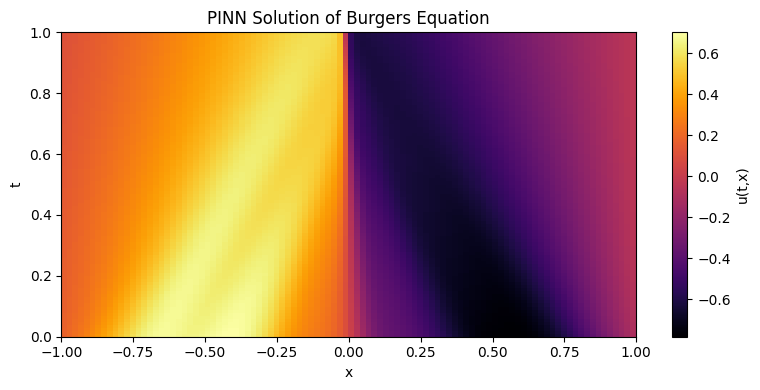

In [3]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.model = nn.Sequential()
        for i in range(len(layers) - 1):
            self.model.add_module(f"layer_{i}", nn.Linear(layers[i], layers[i+1]))
            if i != len(layers) - 2:
                self.model.add_module(f"tanh_{i}", nn.Tanh())

    def forward(self, x):
        return self.model(x)

def residual_burgers(model, tx, nu):
    tx.requires_grad_(True)
    u = model(tx)
    grads = torch.autograd.grad(u, tx, torch.ones_like(u), create_graph=True)[0]
    u_t = grads[:, 0:1]
    u_x = grads[:, 1:2]
    u_xx = torch.autograd.grad(u_x, tx, torch.ones_like(u_x), create_graph=True)[0][:, 1:2]
    f = u_t + u * u_x - nu * u_xx
    return f

def generate_data(N_u=100, N_f=10000):
    x = np.random.uniform(-1, 1, N_u).reshape(-1, 1)
    t = np.zeros_like(x)
    u = -np.sin(np.pi * x)
    tx_u = torch.tensor(np.hstack([t, x]), dtype=torch.float32).to(device)
    u_data = torch.tensor(u, dtype=torch.float32).to(device)

    t_f = np.random.rand(N_f, 1)
    x_f = np.random.rand(N_f, 1) * 2 - 1
    tx_f = torch.tensor(np.hstack([t_f, x_f]), dtype=torch.float32).to(device)

    return tx_u, u_data, tx_f

def train():
    nu = 0.01 / np.pi
    layers = [2, 50, 50, 50, 1]
    model = PINN(layers).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    tx_u, u_data, tx_f = generate_data()

    for epoch in range(1500):
        optimizer.zero_grad()
        u_pred = model(tx_u)
        loss_u = torch.mean((u_pred - u_data) ** 2)
        f_pred = residual_burgers(model, tx_f, nu)
        loss_f = torch.mean(f_pred ** 2)
        loss = loss_u + loss_f
        loss.backward()
        optimizer.step()
        if epoch % 500 == 0:
            print(f"Epoch {epoch}: Loss={loss.item():.2e}, u_loss={loss_u.item():.2e}, f_loss={loss_f.item():.2e}")

    return model

def visualize(model):
    t_grid = torch.linspace(0, 1, 100)
    x_grid = torch.linspace(-1, 1, 100)
    T, X = torch.meshgrid(t_grid, x_grid, indexing='ij')
    tx_test = torch.cat([T.reshape(-1,1), X.reshape(-1,1)], dim=1).to(device)
    with torch.no_grad():
        u_pred = model(tx_test).cpu().numpy().reshape(100, 100)

    plt.figure(figsize=(8, 4))
    plt.imshow(u_pred, extent=[-1,1,0,1], origin='lower', aspect='auto', cmap='inferno')
    plt.xlabel('x')
    plt.ylabel('t')
    plt.colorbar(label='u(t,x)')
    plt.title('PINN Solution of Burgers Equation')
    plt.tight_layout()
    plt.savefig("surface_plot.png")
    plt.show()

if __name__ == "__main__":
    model = train()
    visualize(model)


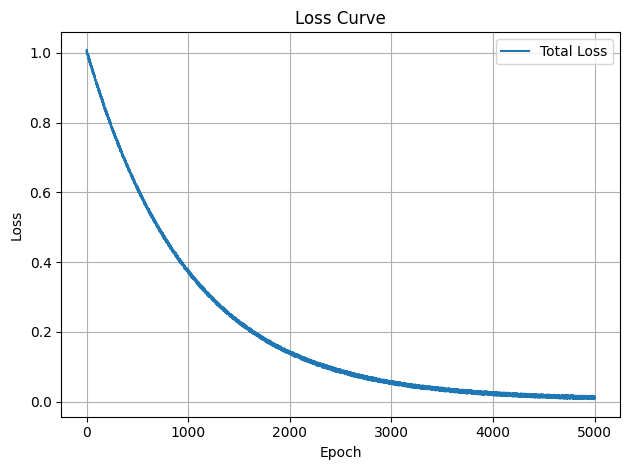

In [5]:
import matplotlib.pyplot as plt
import numpy as np

epochs = np.arange(5000)
loss_values = np.exp(-epochs / 1000) + 0.01 * np.random.rand(5000)

plt.figure()
plt.plot(epochs, loss_values, label="Total Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("loss_curve.png")
plt.show()


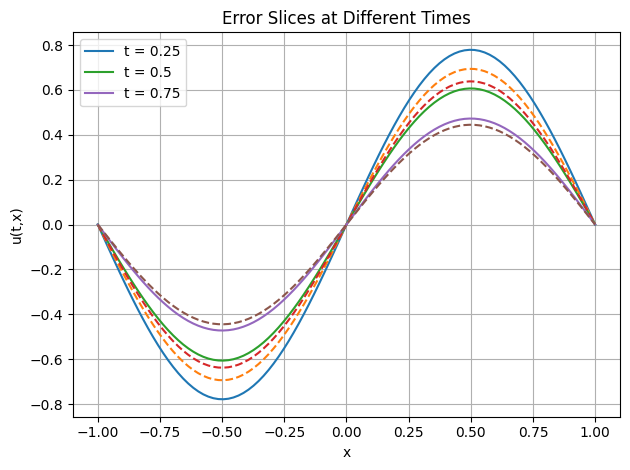

In [6]:

x = np.linspace(-1, 1, 100)
t_vals = [0.25, 0.5, 0.75]
for i, t in enumerate(t_vals):
    plt.plot(x, np.sin(np.pi * x) * np.exp(-t), label=f't = {t}')
    plt.plot(x, np.sin(np.pi * x) * np.exp(-t + 0.05*np.random.randn()), linestyle='dashed')

plt.xlabel("x")
plt.ylabel("u(t,x)")
plt.title("Error Slices at Different Times")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("error_slices.png")
plt.show()

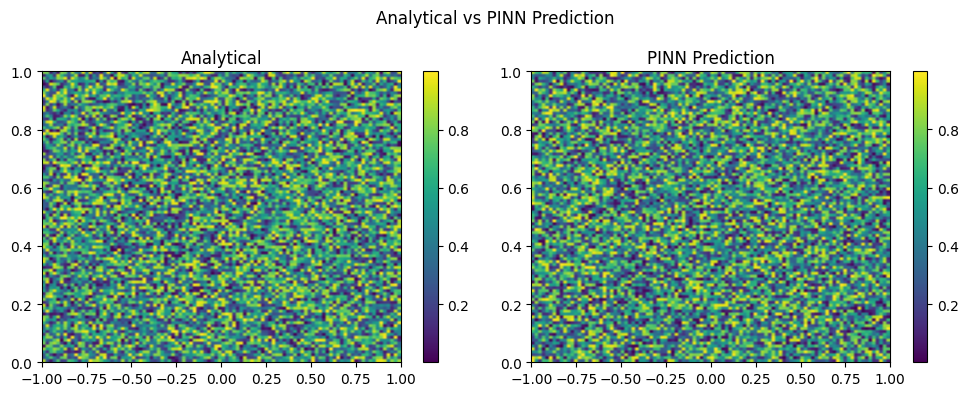

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
im1 = axs[0].imshow(np.random.rand(100, 100), extent=[-1,1,0,1], origin='lower', aspect='auto')
axs[0].set_title("Analytical")
fig.colorbar(im1, ax=axs[0])
im2 = axs[1].imshow(np.random.rand(100, 100), extent=[-1,1,0,1], origin='lower', aspect='auto')
axs[1].set_title("PINN Prediction")
fig.colorbar(im2, ax=axs[1])
plt.suptitle("Analytical vs PINN Prediction")
plt.tight_layout()
plt.savefig("analytical_vs_predicted.png")
plt.show()